In [7]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
BASE_PATH = "../results/all_limitless/baati"

def readAppData(path, skiprows=28):
    df = pd.read_csv(path, skiprows=skiprows, parse_dates=True)
    df["datetime"] = pd.to_datetime(df["time_h"])
    return df
    
def readResData(path):
    res = pd.read_csv(path)
    res["datetime"] = pd.to_datetime(res["time"], utc=True)
    return res
    
def readExp(expid):
    paths = glob.glob(os.path.join(expid.path, "VM_runtime_app_*.csv"))
    if len(paths) != 1:
        raise ValueError(f"Unexpeted number of performance data files {len(paths)} != 1 for " \
                f"{expid.path}")
    return readAppData(paths[0])


def dfInterval(df, tmin, tmax):
    return (tmin <= df["datetime"]) & (df["datetime"] <= tmax)

def getSplitIntervals(df):
    ais = df["ai_name"].unique()
    tss = [df.loc[df["ai_name"] == ai, "datetime"].min() for ai in ais]
    tss.append(df["datetime"].max())
    tss.sort()
    return list(zip(tss[:-1], tss[1:]))

def splitDF(df, timestampDF=None, ai_name="ai_1"):
    if timestampDF is None:
        timestampDF = df
    tss = getSplitIntervals(timestampDF)
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[dfInterval(df, *ts)] for ts in tss]


def getMetrics(dfs, metric_name="app_latency"):
    metric = np.array([df2[metric_name].mean() for df2 in dfs])
    stddev = np.array([df2[metric_name].std() for df2 in dfs])
    return metric, stddev

def plotPerf(df, expid, metric_name="app_latency"):
    dfs = splitDF(df)
    fig, ax = plt.subplots()
    metric, metric_stddev = getMetrics(dfs)
    ax.errorbar(range(1, len(metric)+1), metric, yerr=metric_stddev)
    ax.set_ylabel(metric_name)
    ax.set_title(expid.expid)
    plt.show()
    
def plotRegressionLine(ax, x, y, yerr, b, expid=None, metric_name="app_latency"): 
    x = np.array(x)
    ax.errorbar(x, y,yerr, color = "m", fmt="o") 
    #plt.scatter(x, y, color = "m", yerr=yerr, 
    #           marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    ax.plot(x, y_pred, color = "g") 
    #plt.show()
    
def getXs(ys):
    return list(range(1, len(ys)+1))

def fitRegression(ys):
    xs2 = [[i] for i in getXs(ys)]
    reg = linear_model.LinearRegression()
    reg.fit(xs2, ys)
    return np.array([reg.intercept_, reg.coef_[0]])

# expid, t1, t2, ai_name, tasks, avg_latency, avg_throughput, std_latency, std_throughput, latency_samples_count
def analizeData(expid, ax, metric_name="app_latency", rescale=False, silent=False):
    print(expid.expid)
    df = readExp(expid)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    if rescale:
        factor = ys[0]
        ys /= factor
        yerr /= factor
    coef = fitRegression(ys)
    if not silent:
        plotRegressionLine(ax, getXs(ys), ys, yerr, coef, expid, metric_name)
    return coef

"""
# TODO print cost function
"""
def analyzeInterferenceGrid(exp_series, rescale=True, silent=False):
    results = []
    n = len(exp_series.tasks)
    def formatLegend(ax, t1, t2, metric, i, j):
        if not i:
            ax.set_title(f"influence of {t2}")
        if i == n-1:
            ax.set_xlabel('number of tasks') 
        if not j:
            ax.set_ylabel(f"{t1} - {metric}") 
    fig, axes = plt.subplots(n, n, figsize=(15., 15.))
    for i, t1 in enumerate(exp_series.tasks):
        for j, t2 in enumerate(exp_series.tasks):
            ax = axes[i, j]
            metric = "app_throughput" if t1 == "linpack" else "app_latency"
            sign = -1. if metric == "app_throughput" else 1.
            formatLegend(ax, t1, t2, metric, i, j)
            try:
                expid = exp_series.getExperiment(t1, t2)
            except KeyError:
                print(f"WARNING: No experiment data for {t1} {t2}")
                results.append(0.)
            else:
                coefs = analizeData(expid, ax, metric_name=metric, \
                                    rescale=rescale, silent=silent)
                results.append(coefs[1] * sign)
    plt.show()
    results = np.array(results)
    results.resize([n, n])
    return np.array(results)

class ExperimentRecord:
    def __init__(self, t1, t2, path, exp_series):
        self.t1 = t1 # Task type 1
        self.t2 = t2 # Task type 2
        self.path = path
        self.base_path, self.expid = os.path.split(path)
        self.exp_series = exp_series
        
class ExperimentSeries:
    def __init__(self, path, tasks, ai_role_count={}):
        self.tasks = tasks
        self.path = path
        _, self.name = os.path.split(path)
        self.type_pair_to_exp = dict()
        for t1 in tasks:
            for t2 in tasks:
                exp_paths = self.getExperimentPaths(t1, t2, path)
                if len(exp_paths) > 1:
                    raise ValueError(f"Found {len(exp_paths)}>1 experiment records for types " \
                        f"{t1} {t2} in directory {path}")
                elif len(exp_paths) == 1:
                    self.type_pair_to_exp[(t1, t2)] = ExperimentRecord(t1, t2, exp_paths[0], self)
                else:
                    print(f"Missing record for {t1} {t2}")
        print(f"Found {len(self.type_pair_to_exp)} experiment in series {self.name}")
        
        ai_type_role = dict()
        ai_type_role["redis_ycsb"] = ["ycsb", "redis"]
        ai_type_role["hadoop"] = ["hadoopmaster", "hadoopslave"]
        ai_type_role["linpack"] = ["linpack"]
        ai_type_role["wrk"] = ["wrk", "apache"]
        self.ai_type_role = ai_type_role
        
        self.ai_role_count = {}
        for _, ai_roles in self.ai_type_role.items():
            for ai_role in ai_roles:
                self.ai_role_count[ai_role] = 1
        self.ai_role_count.update(ai_role_count)
        
    @staticmethod
    def getExperimentPaths(t1, t2, base_path):
        expid = t1 if t1 == t2 else f"{t1}_{t2}"
        def matchExpidRegex(e):
            expid_regex = "[0-9]{0,4}" + expid
            i = e.split("/")[-1]
            return bool(re.fullmatch(expid_regex, i))

        pattern = os.path.join(base_path, f"*{expid}")
        expids = glob.glob(pattern)
        return [e for e in expids if matchExpidRegex(e)]
        
    def getExperiment(self, t1, t2):
        return self.type_pair_to_exp[(t1, t2)]

"""
Performance vs cpu
"""

"""
Functions for CPU data parsing.
"""
def getResDataPaths(expid, ai_no, role, resource):
    paths = glob.glob(os.path.join(expid.path, \
        f"resources/metric_pod_*{role}-ai-{ai_no+1}_{resource}.csv"))
    expected_count = expid.exp_series.ai_role_count[role]
    if len(paths) != expected_count:
        raise ValueError(f"Unexpected number of resources {len(paths)} != {expected_count} for " \
            f"{expid.expid} {role} {ai_no+1} {resource}")
    return paths

def toSingleRowDF(d):
    d2 = {}
    for k, v in d.items():
        d2.update({k: pd.Series(v, index=[0])})
    return pd.DataFrame(d2)

# DF: expid, t1, t2, ai_no, ai_role, tasks, avg_cpu, std_cpu, cpu_samples_count
def getResourceDatapoint(expid, ai_no, ai_role, tasks, ts, df):
    df = df.loc[dfInterval(df, *ts), ["datetime", "value"]]
    values = df["value"]
    d = {"expid": expid.expid, "t1": expid.t1, "t2": expid.t2, "ai_no": ai_no+1}
    d.update({"ai_role": ai_role, "tasks": tasks+1})
    if values.count() == 0:
        raise ValueError(f"No data samples for {expid.expid} {ai_no+1} {ai_role} {tasks}")
    d.update({"avg_cpu": values.mean(), "std_cpu": values.std(), "cpu_samples_count": values.count()})
    return toSingleRowDF(d)

def getResourceDatapointsSingleFile(expid, ai_no, ai_role, tss, df):
    results = pd.DataFrame()
    for tasks in range(ai_no, len(tss)):
        result = getResourceDatapoint(expid, ai_no, ai_role, tasks, tss[tasks], df)
        results = results.append(result, ignore_index=True)
    return results
            
def getResourceDatapoints(expid, ai_no, tss):
    results = pd.DataFrame()
    t = expid.t1 if ai_no == 0 else expid.t2
    for ai_role in expid.exp_series.ai_type_role[t]:
        paths = getResDataPaths(expid, ai_no, ai_role, "cpu")
        for path in paths:
            df = readResData(path)
            result = getResourceDatapointsSingleFile(expid, ai_no, ai_role, tss, df)
            results = results.append(result, ignore_index=True)
    return results

# cpu, cpu_aggregate, perf_cpu
def getCpuData(exp_series):
    print("Getting cpu data")
    results = pd.DataFrame()
    for t1 in exp_series.tasks:
        for t2 in exp_series.tasks:
            try:
                expid = exp_series.getExperiment(t1, t2)
            except KeyError:
                print(f"WARNING: No experiment data for {t1} {t2}")
            else:
                df = readExp(expid)
                tss = getSplitIntervals(df)
                max_ais = len(tss)
                for ai_no in range(max_ais):
                    result = getResourceDatapoints(expid, ai_no, tss)
                    results = results.append(result, ignore_index=True)
    return results

def getCpuAggregate(cpu):
    print("Aggregating cpu data")
    cpu_sum = cpu.groupby(["expid", "t1", "t2", "tasks"], as_index=False).sum()
    cpu_sum.pop("ai_no")
    return cpu_sum

def getCpuDataAll(exp_series):
    cpu = getCpuData(exp_series)
    agg = getCpuAggregate(cpu)
    return {"cpu": cpu, "cpu_agg": agg}

"""
Functions for performance data parsing.
"""
# expid, t1, t2, ai_name, tasks
def getPerfAggregate(input_df):
    print("Aggregating perf data")
    results = pd.DataFrame()
    for expidString in input_df["expid"].unique():
        df = input_df[input_df["expid"] == expidString]
        tss = getSplitIntervals(df)
        ai_count = len(tss)
        for ai_no in range(ai_count):
            for tasks in range(ai_no, ai_count):
                ai_name = f"ai_{ai_no+1}"
                local_df = df[dfInterval(df, *tss[tasks]) & (df["ai_name"] == ai_name)]
                d = {"expid": expidString, "ai_no": ai_no+1, "tasks": tasks+1}
                for metric in ["app_latency", "app_throughput"]:
                    if np.any(pd.isna(local_df[metric])):
                        continue
                    perf = local_df[metric]
                    m = metric[len("app_"):]
                    d.update({f"avg_{m}": perf.mean(), f"std_{m}": perf.std()})
                    d.update({f"{m}_samples_count": perf.count()})
                results = results.append(toSingleRowDF(d), ignore_index=True)
    return results

def getPerfData(exp_series):
    print("Getting perf data")
    results = pd.DataFrame()
    for expid in exp_series.type_pair_to_exp.values():
        df = readExp(expid)
        df["expid"] = expid.expid
        results = results.append(df, ignore_index=True)
    return results
                
def getPerfDataAll(exp_series):
    perf = getPerfData(exp_series)
    agg = getPerfAggregate(perf)
    return {"perf": perf, "perf_agg": agg}
    
def getPerfVsCpu(cpu_res, perf_res):
    result = {}
    result.update(cpu_res)
    result.update(perf_res)
    result["perf_vs_cpu"] = result["cpu_agg"].merge(result["perf_agg"], on=["expid", "tasks"])
    return result
    
"""
Functions for analyzing performance vs cpu.
"""
task_to_color = {"redis_ycsb": "green", "wrk": "blue", "linpack": "yellow", "hadoop": "red"}
def printPerfVsCpu(input_df, rescale=True):
    t1s = input_df["t1"].unique()
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = [ax for axs1 in axs for ax in axs1]
    if len(t1s) == 1:
        axs = [axs]
        
    for i, t1 in enumerate(t1s):
        metric = "throughput" if t1 == "linpack" else "latency"
        avg_metric = f"avg_{metric}"
        std_metric = f"avg_{metric}"
        axs[i].set_title(f"performance of {t1}")
        selected_rows = (input_df["t1"] == t1) & (input_df["ai_no"] == 1)
        if rescale:
            factor = input_df.loc[selected_rows & (input_df["tasks"] == 1), avg_metric].mean()
            input_df.loc[selected_rows, avg_metric] /= factor
            input_df.loc[selected_rows, std_metric] /= factor
        df = input_df.loc[selected_rows, :]
        for t2 in sorted(df["t2"].unique()):
            df2 = df.loc[df["t2"] == t2, :]
            #axs[i].scatter(df2["avg_cpu"], df2[avg_metric], color=task_to_color[t2], label=t2)
            axs[i].scatter(df2["avg_cpu"], df2[avg_metric], label=t2)
        axs[i].legend()
    plt.show()

def analyzePerfVsCpu(exp_series):
    print(f"perf vs cpu {exp_series.path}")
    cpu_res = getCpuDataAll(exp_series)
    perf_res = getPerfDataAll(exp_series)
    result = getPerfVsCpu(cpu_res, perf_res)
    printPerfVsCpu(result["perf_vs_cpu"])
    return result

def getResourceSinglePod(expid, role, ts, resource="cpu", ai="ai-1"):
    tmin, tmax = ts
    paths = getResDataPaths(expid, 0, role, resource)
    res = readResData(paths[0])
    return res.loc[dfInterval(res, tmin, tmax), ["datetime", "value"]]

def getResourceLimitsRecord(ai_type, ai_role, resource, df):
    result = {"type": ai_type, "role": ai_role, "resource": resource}
    if resource == "cpu":
        unit = "m" # milicores
    elif resource == "memory":
        df["value"] = df["value"] / 2 ** 20
        unit = "Mi"
    else:
        raise ValueError(f"Unsupported resource type {resource}")
    values = df["value"]
    result.update({"avg": values.mean(), "std": values.std(), "min": values.min(), "max": values.max()})
    result.update({"unit": unit})
    return result

def getResourceLimits(exp_series):
    results = pd.DataFrame()
    for ai_type, roles in exp_series.ai_type_role.items():
        expid = exp_series.getExperiment(ai_type, ai_type)
        print(expid.expid)
        df = readExp(expid)
        tmax = df.loc[df["ai_name"] == "ai_2", "datetime"].min()
        tmin = df.loc[df["ai_name"] == "ai_1", "datetime"].min()
        ts = (tmin, tmax)
        for role in roles:
            for resource in ["cpu", "memory"]:
                df = getResourceSinglePod(expid, role, ts, resource)
                record = getResourceLimitsRecord(ai_type, role, resource, df)
                results = results.append(toSingleRowDF(record), ignore_index=True)
    return results

In [77]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/1all_limitless" 
s1 = ExperimentSeries(path, tasks)
path = "data/2more_tasks" 
s2 = ExperimentSeries(path, tasks)

Found 16 experiment in series 1all_limitless
Missing record for linpack wrk
Found 15 experiment in series 2more_tasks


In [13]:
"""
Check if all experiments have expected number of virtual applications
"""
paths = glob.glob("data/1*")
for path in paths: 
    expid_splitted = path.split("/")
    if len(expid_splitted) < 2:
        print(f"skipping path {path}")
        continue
    expid = expid_splitted[1]
    print(f"Checking {expid}")
    df = readExp(expid, base_path="data")
    print(f"{expid}: {len(df['ai_name'].unique())}")


Checking 106wrk
106wrk: 15
Checking 107wrk_linpack
107wrk_linpack: 15
Checking 105wrk_redis_ycsb
105wrk_redis_ycsb: 15
Checking 104redis_ycsb_hadoop
104redis_ycsb_hadoop: 15
Checking 108wrk_hadoop
108wrk_hadoop: 6
Checking 115hadoop_linpack
115hadoop_linpack: 6
Checking 110linpack_wrk
110linpack_wrk: 14
Checking 118linpack_wrk
118linpack_wrk: 12
Checking 116hadoop
116hadoop: 6
Checking 111linpack
111linpack: 15
Checking 103redis_ycsb_linpack
103redis_ycsb_linpack: 15
Checking 101redis_ycsb
101redis_ycsb: 15
Checking 112linpack_hadoop
112linpack_hadoop: 6
Checking 109linpack_redis_ycsb
109linpack_redis_ycsb: 15
Checking 102redis_ycsb_wrk
102redis_ycsb_wrk: 15
Checking 113hadoop_redis_ycsb
113hadoop_redis_ycsb: 15
Checking 114hadoop_wrk
114hadoop_wrk: 6


# Performance vs cpu

In [81]:
#limits
#limits.to_csv("resource.csv")
limits = getResourceLimits(s2)
limits

101redis_ycsb
116hadoop
111linpack
106wrk


,type,role,resource,avg,std,min,max,unit
0,redis_ycsb,ycsb,cpu,1142.476190,67.610368,883.000000,1236.000000,m
1,redis_ycsb,ycsb,memory,205.555246,65.958483,109.031250,356.503906,Mi
2,redis_ycsb,redis,cpu,225.000000,23.522330,140.000000,253.000000,m
3,redis_ycsb,redis,memory,34.331845,7.037553,20.675781,39.601562,Mi
4,hadoop,hadoopmaster,cpu,618.869565,401.603299,40.000000,1162.000000,m
5,hadoop,hadoopmaster,memory,1235.652853,86.375980,1060.312500,1325.316406,Mi
6,hadoop,hadoopslave,cpu,874.913043,558.214924,6.000000,1796.000000,m
7,hadoop,hadoopslave,memory,957.867357,179.151272,682.125000,1274.367188,Mi
8,linpack,linpack,cpu,1783.045455,71.285795,1536.000000,1891.000000,m
9,linpack,linpack,memory,313.657138,55.224488,135.433594,341.031250,Mi


In [86]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/1all_limitless" 
s1 = ExperimentSeries(path, tasks)
path = "data/2more_tasks" 
s2 = ExperimentSeries(path, tasks)
#perf_vs_cpu_res = analyzePerfVsCpu(s1)
#printPerfVsCpu(perf_vs_cpu_res["perf_vs_cpu"])

Found 16 experiment in series 1all_limitless
Missing record for linpack wrk
Found 15 experiment in series 2more_tasks


perf vs cpu data/2more_tasks
Getting cpu data
Aggregating cpu data
Getting perf data
Aggregating perf data


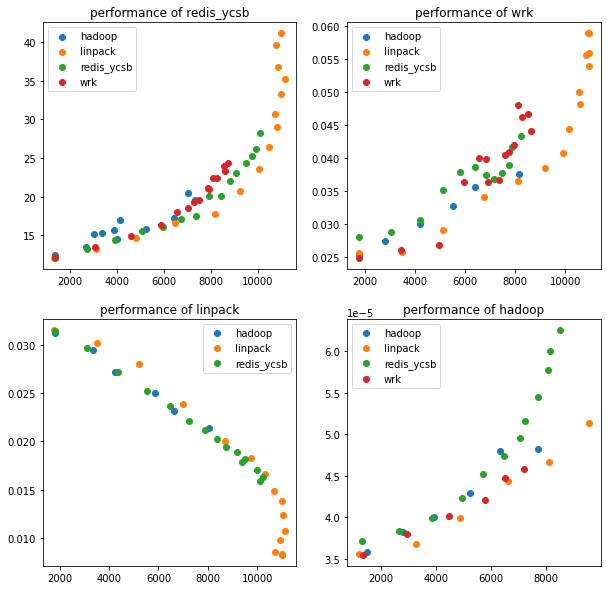

In [82]:
perf_vs_cpu_res_new = analyzePerfVsCpu(s2)
#res = perf_vs_cpu_res_new["cpu"]
#res.loc[(res["t1"] == "linpack") & (res["t2"] == "wrk") & (res["cpu_samples_count"] == 0) \
#        & (res["ai_role"] == "linpack"), :]

#expid = s2.getExperiment("linpack", "wrk")
#path = getResDataPaths(expid, 0, "linpack", "cpu")[0]
#res2 = readResData(path)
#res2
#df = readExp(expid)
#df

#printPerfVsCpu(perf_vs_cpu_res_new["perf_vs_cpu"])

In [90]:
# Checks:
# There are resource records for all ais and  all roles
# There are non zero number of samples



perf = perf_vs_cpu_res_new["perf_agg"]
#perf.info()
t1 = "linpack"
t2 = t1
expid = "data/111linpack"
perf["expid"].unique()
r = perf.loc[(perf["expid"] == expid) & (perf["ai_no"] <= perf["tasks"]) & (perf["throughput_samples_count"].notna()),["tasks", "ai_no", "throughput_samples_count"]]
r.describe()

,tasks,ai_no,throughput_samples_count
count,120.000000,120.000000,120.000000
mean,10.333333,5.666667,49.500000
std,3.651484,3.651484,23.723194
min,1.000000,1.000000,23.000000
25%,8.000000,3.000000,34.000000
50%,11.000000,5.000000,41.500000
75%,13.000000,8.000000,59.000000
max,15.000000,15.000000,126.000000


# Performance vs number of tasks

In [3]:

#interference = analyzeInterferenceGrid(s1)
#print(interference)

101redis_ycsb
102redis_ycsb_wrk
172redis_ycsb_hadoop
103redis_ycsb_linpack
174wrk_redis_ycsb
106wrk
108wrk_hadoop
107wrk_linpack
178hadoop_redis_ycsb
114hadoop_wrk
116hadoop
115hadoop_linpack
109linpack_redis_ycsb
112linpack_hadoop
111linpack


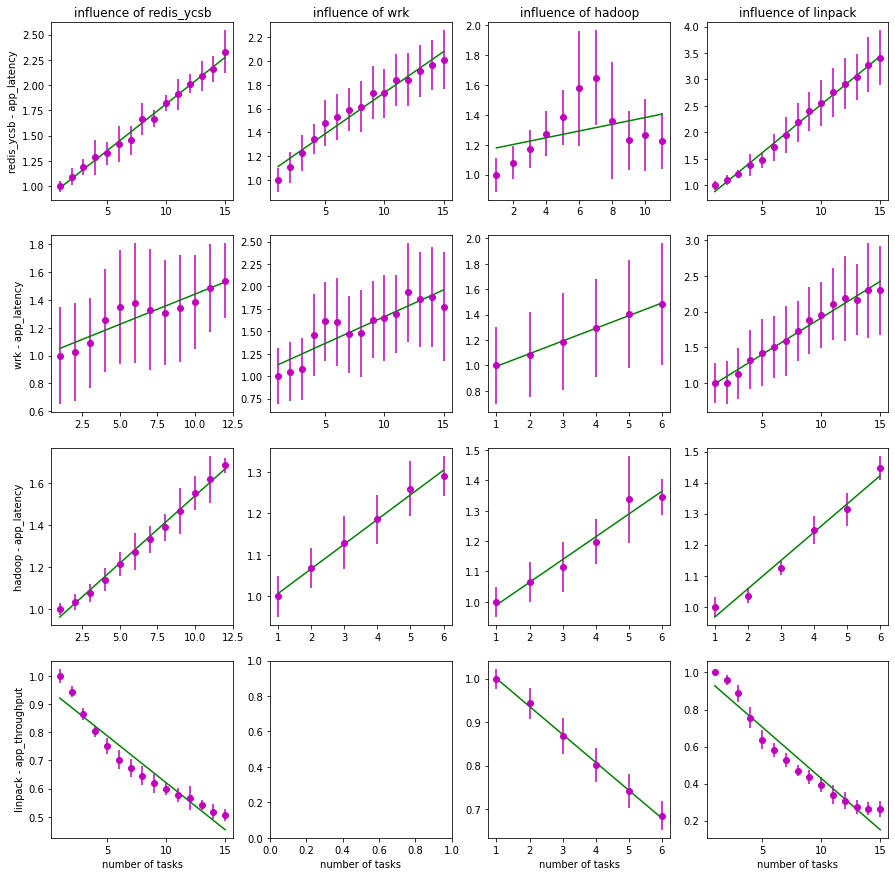

[[0.09251838 0.06896643 0.02253664 0.18303585]
 [0.04346423 0.05950165 0.0996998  0.10239049]
 [0.06407131 0.05943509 0.07495003 0.0910561 ]
 [0.03340253 0.         0.06426189 0.05550344]]


In [93]:
interference = analyzeInterferenceGrid(s2)
print(interference)

202redis_ycsb_hadoop
230hadoop
271hadoop_linpack
214linpack_hadoop


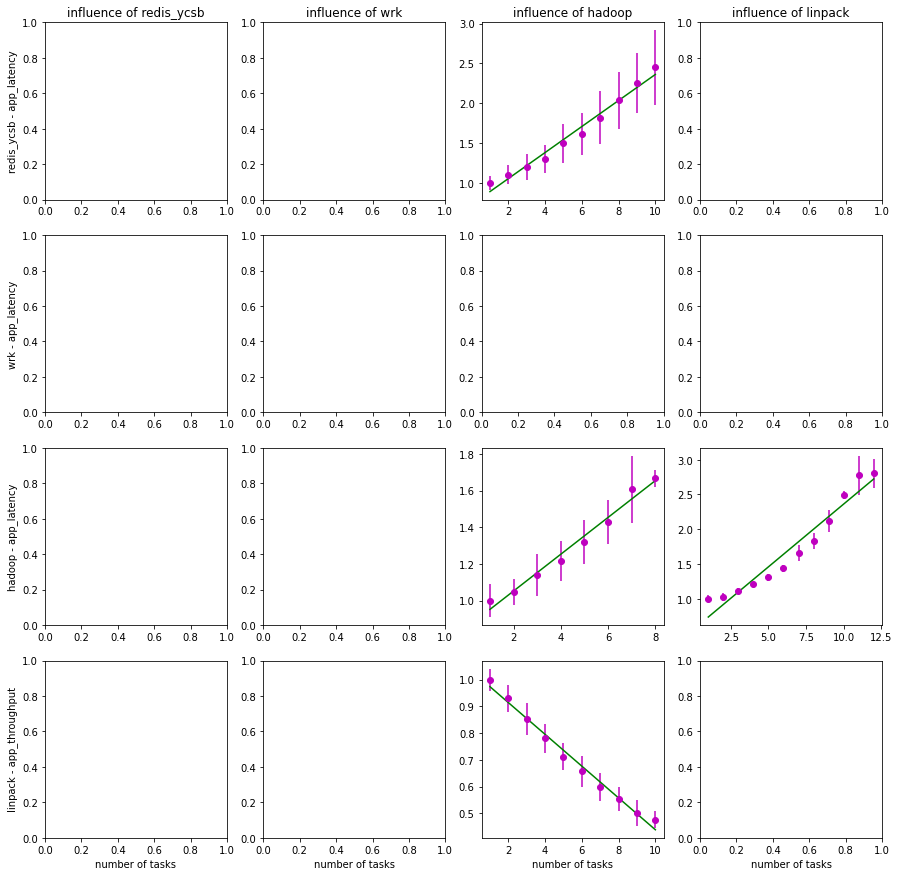

array([[0.        , 0.        , 0.16339007, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.10029655, 0.18047888],
       [0.        , 0.        , 0.05947115, 0.        ]])

In [68]:
analyzeInterferenceGrid(s3)

In [94]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/3more_tasks_hadoop" 
#s3 = ExperimentSeries(path, tasks, {"hadoopslave": 2})
#df = pd.read_csv("data/268hadoop_redis_ycsb/processed_VM_runtime_app_268hadoop_redis_ycsb.csv")
#df["datetime"] = pd.to_datetime(df["time"], utc=True)
#print(df.loc[:, ["time_cbtool", "time_cbtool_h", "app_latency"]])
#analizeData2(s3.getExperiment("hadoop", "redis_ycsb"), ax)
#analyzeInterferenceGrid(s3)

#s3_cpu_vs_perf = analyzePerfVsCpu(s3)
cpu = s3_cpu_vs_perf["cpu_agg"]
perf = s3_cpu_vs_perf["perf"]
df = s3_cpu_vs_perf["perf_vs_cpu"]
df = perf

#pd.set_option('display.max_rows', 50)
#df.loc[(df["t1"] == "linpack") & (df["t2"] == "hadoop"), :]
tmin = df.loc[(df["expid"] == "214linpack_hadoop") & (df["ai_name"] == "ai_2"), "datetime"].min()
tmi2 = df.loc[(df["expid"] == "214linpack_hadoop") & (df["ai_name"] == "ai_1"), "datetime"].min()

print(tmin)
pd.set_option("display.max_columns", 20)
df.loc[(df["expid"] == "214linpack_hadoop") & (df["ai_name"] == "ai_1") & (df["datetime"] < tmin) & (df["app_throughput"].notna()), ["datetime", "app_throughput"]]

#printPerfVsCpu(s3_cpu_vs_perf["perf_vs_cpu"])

2020-05-04 14:04:05+00:00


,datetime,app_throughput
6894,2020-05-04 13:39:20+00:00,33.0167
6895,2020-05-04 13:39:30+00:00,33.2740
6896,2020-05-04 13:39:40+00:00,32.6059
6897,2020-05-04 13:39:50+00:00,33.2131
6898,2020-05-04 13:40:00+00:00,33.1805
...,...,...
7035,2020-05-04 14:03:16+00:00,28.7596
7036,2020-05-04 14:03:26+00:00,31.7184
7037,2020-05-04 14:03:37+00:00,30.4386
7038,2020-05-04 14:03:49+00:00,28.9179


In [94]:
# hokey curve for redis_ycsb on naan

In [95]:
result = {}
for t in s2.tasks:
    expid = s2.getExperiment(t, t)
    print(expid.expid)
    result[expid.expid] = readExp(expid)
print(result.keys())

completion_time = []
for expid, df in result.items():
    print(expid)
    c = df.loc[df["ai_name"] == "ai_1" , "app_completion_time"].mean()
    completion_time.append(c)
print(completion_time)
    
#print(result.keys())
#for expid, r in result.items():
#    r2 = r.loc[r["ai_name"] == "ai_1", "app_completion_time"]
#    print(expid)
#    print(r2.describe())

101redis_ycsb
106wrk
116hadoop
111linpack
dict_keys(['101redis_ycsb', '106wrk', '116hadoop', '111linpack'])
101redis_ycsb
106wrk
116hadoop
111linpack
[1.8918032786885246, 1.4427906976744187, 44.79381443298969, 17.24773413897281]
